In [0]:
%matplotlib inline

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

## Load Dataset

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

170500096it [00:04, 39293233.93it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Enable CUDA

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

cuda:0


### Quick Tutorial

The rest of this section assumes that `device` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:



    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:



    inputs, labels = inputs.to(device), labels.to(device)

## Define Example Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Example Optimizer

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train Example Model

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.188
[1,  4000] loss: 1.891
[1,  6000] loss: 1.678
[1,  8000] loss: 1.575
[1, 10000] loss: 1.534
[1, 12000] loss: 1.493
[2,  2000] loss: 1.399
[2,  4000] loss: 1.371
[2,  6000] loss: 1.365
[2,  8000] loss: 1.327
[2, 10000] loss: 1.299
[2, 12000] loss: 1.274
Finished Training


## Define Test Accuracy Function

In [0]:
def get_test_accuracy(model, device):
  correct = 0
  total = 0
  model.to(device)
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return 100 * correct / total

## Compute Test Accuracy 4 Example

In [9]:
accuracy = get_test_accuracy(net, device)
print(f'Accuracy of the network on the 10000 test images: {accuracy}%')

Accuracy of the network on the 10000 test images: 53.72%


## Task 1 - Example Model Evaluation
For recently trained model calculate accuracy, precision, recall, f1-score and print it. Construct confusion matrix.

In [0]:
import sklearn.metrics as metrics
import numpy as np
from matplotlib import pyplot as plt

### Define useful functions

In [0]:
# lets form a confusion matrix!
# ..and predicted labels array

y_true = np.array(testset.targets, dtype=int)

def get_predictions_confusion(model):

  model.to(device)

  confusion_matrix = np.zeros((10,10))
  y_pred = np.zeros(y_true.shape, dtype=int)
  j = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)

          for i in range(labels.shape[0]):
              true_label = labels[i]
              pred_label = predicted[i]

              confusion_matrix[true_label, pred_label] += 1

              y_pred[j] = pred_label
              j += 1
  return y_pred, confusion_matrix


In [0]:
# plot confusion matrix
def plot_confusion(model, confusion_matrix):
  # normalize confusion matrix
  normalized_confusion = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

  # plot confusion matrix
  disp = metrics.ConfusionMatrixDisplay(normalized_confusion,
                                    display_labels=classes)

  fig, ax = plt.subplots(figsize=(10,10))
  return disp.plot(ax=ax)

In [0]:
# compute precision, recall, f1 score
def precision_recall_f1(model, y_true, y_pred):

  precision, recall, f1score, _ = metrics.precision_recall_fscore_support(
      y_true, y_pred,
      # average='samples',
      labels=list(range(10))
    )
  print("Class  |   Precision  Recall  F1-score \n")

  for i in range(10):
    print("{cls}     {prc}  {rcl}  {f1}".format(
        cls = classes[i],
        prc = precision[i],
        rcl = recall[i],
        f1 = f1score[i]
    ))

### Use these functions for getting demanded metrics

In [0]:
y_pred, confusion = get_predictions_confusion(net)

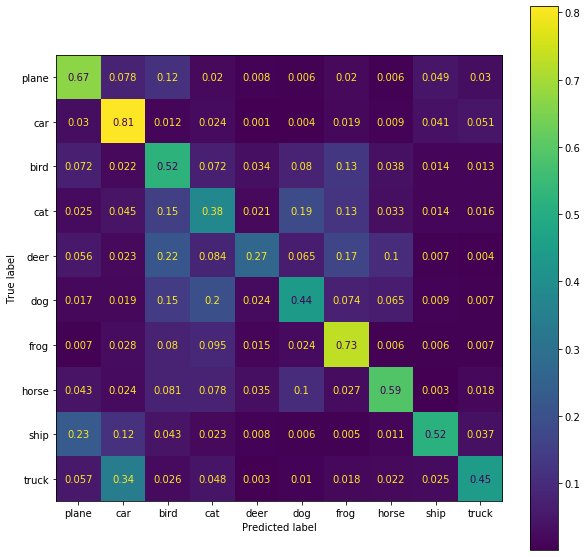

In [15]:
plot_confusion(net, confusion)

In [16]:
# compute accuracy score (idk why i left this cell when i have a function but ok)
print("Model accuracy: {}".format(
    100 * confusion.trace() / confusion.sum()
))

Model accuracy: 53.72


In [17]:
precision_recall_f1(net, y_true, y_pred)

Class  |   Precision  Recall  F1-score 

plane     0.5521523178807947  0.667  0.6041666666666666
car     0.5357615894039736  0.809  0.6446215139442231
bird     0.3745532523230879  0.524  0.436848686952897
cat     0.37095191364082436  0.378  0.37444279346211
deer     0.6435406698564593  0.269  0.3794076163610719
dog     0.47680690399137  0.442  0.4587441619097042
frog     0.552870090634441  0.732  0.6299483648881239
horse     0.6678004535147393  0.589  0.6259298618490967
ship     0.7543859649122807  0.516  0.6128266033254156
truck     0.7090620031796503  0.446  0.5475751995089012


## Task 2 - Define My Own Model

Modify Better_net and training process to achieve 90% accuracy on CIFAR10 dataset (higher is better)

### Define Model Train & Test Functions

In [0]:
def train(model, optimizer,criterion, epoch, log_interval, train_loader=trainloader, device=device):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if (batch_idx % 100 == 0):
            print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
               % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

def test(model, device, test_loader=testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100. * correct / total
    print('Accuracy of the network on the test images: %.3f %%' % (accuracy))
    return accuracy

### Change batch size

In [0]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

### Define Model Architecture

I used VGG19 as a skeleton and tuned it a bit.

In [0]:
# vgg 19
class VGG(nn.Module):
    def __init__(self, enable_dropout=True):
        super(VGG, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64,64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(64,128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # x3

        # x2
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)  # x3

        self.linear1 = nn.Linear(512, 256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, 10)


        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.AvgPool2d(kernel_size=1, stride=1)

        self.norm64  = nn.BatchNorm2d(64)
        self.norm128 = nn.BatchNorm2d(128)
        self.norm256 = nn.BatchNorm2d(256)
        self.norm512 = nn.BatchNorm2d(512)

        self.norm1d1 = nn.BatchNorm1d(512)
        self.norm1d2 = nn.BatchNorm1d(256)

        self.drop2d1 = nn.Dropout2d(0.2)
        self.drop2d2 = nn.Dropout2d(0.3)
        self.drop2d3 = nn.Dropout2d(0.4)

        self.drop1d = nn.Dropout(0.4)

        if enable_dropout:
            self.architecture = self.train_architecture
        else:
            self.architecture = self.test_architecture

    def enable_dropout(self):
        self.architecture = self.train_architecture

    def disable_dropout(self):
        self.architecture = self.test_architecture

    def train_architecture(self, x):
        x = F.relu(self.norm64(self.conv1(x)))
        x = self.drop2d1(x)
        x = F.relu(self.norm64(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.norm128(self.conv3(x)))
        x = self.drop2d2(x)
        x = F.relu(self.norm128(self.conv4(x)))
        x = self.pool1(x)

        x = F.relu(self.norm256(self.conv5(x)))
        x = self.drop2d2(x)
        x = F.relu(self.norm256(self.conv6(x)))
        x = self.drop2d2(x)
        x = F.relu(self.norm256(self.conv6(x)))
        x = self.drop2d2(x)
        x = F.relu(self.norm256(self.conv6(x)))
        x = self.pool1(x)

        x = F.relu(self.norm512(self.conv7(x)))
        x = self.drop2d3(x)
        x = F.relu(self.norm512(self.conv8(x)))
        x = self.drop2d3(x)
        x = F.relu(self.norm512(self.conv8(x)))
        x = self.drop2d3(x)
        x = F.relu(self.norm512(self.conv8(x)))
        x = self.pool1(x)

        x = F.relu(self.norm512(self.conv8(x)))
        x = self.drop2d3(x)
        x = F.relu(self.norm512(self.conv8(x)))
        x = self.drop2d3(x)
        x = F.relu(self.norm512(self.conv8(x)))
        x = self.drop2d3(x)
        x = F.relu(self.norm512(self.conv8(x)))
        x = self.pool1(x)

        x = self.pool2(x)
        x = x.view(-1, 512)
        x = self.norm1d1(x)
        x = self.drop1d(x)
        x = F.relu(self.linear1(x))
        x = self.norm1d2(x)
        x = self.drop1d(x)
        x = F.relu(self.linear2(x))
        x = self.norm1d2(x)
        x = self.drop1d(x)
        x = self.linear3(x)
        return x

    def test_architecture(self, x):
        x = F.relu(self.norm64(self.conv1(x)))
        x = F.relu(self.norm64(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.norm128(self.conv3(x)))
        x = F.relu(self.norm128(self.conv4(x)))
        x = self.pool1(x)

        x = F.relu(self.norm256(self.conv5(x)))
        x = F.relu(self.norm256(self.conv6(x)))
        x = F.relu(self.norm256(self.conv6(x)))
        x = F.relu(self.norm256(self.conv6(x)))
        x = self.pool1(x)

        x = F.relu(self.norm512(self.conv7(x)))
        x = F.relu(self.norm512(self.conv8(x)))
        x = F.relu(self.norm512(self.conv8(x)))
        x = F.relu(self.norm512(self.conv8(x)))
        x = self.pool1(x)

        x = F.relu(self.norm512(self.conv8(x)))
        x = F.relu(self.norm512(self.conv8(x)))
        x = F.relu(self.norm512(self.conv8(x)))
        x = F.relu(self.norm512(self.conv8(x)))
        x = self.pool1(x)

        x = self.pool2(x)
        x = x.view(-1, 512)
        x = self.norm1d1(x)
        x = F.relu(self.linear1(x))
        x = self.norm1d2(x)
        x = F.relu(self.linear2(x))
        x = self.norm1d2(x)
        x = self.linear3(x)
        return x

    def forward(self, x):
        return self.architecture(x)

In [0]:
vgg = VGG().to(device)

### Train & Test Model

In [0]:
criterion = nn.CrossEntropyLoss().to(device)
learning_rate = 0.001
optimizer = optim.SGD(
    vgg.parameters(), 
    lr=0.001, momentum=0.9, 
    weight_decay=0.01
    )

In [37]:
# first learning rate
epochs = 100
log_interval = 100
vgg.enable_dropout()
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}")
    train(vgg, optimizer, criterion, epoch, log_interval, device=device)
    vgg.disable_dropout()
    acc = test(vgg, device)
    vgg.enable_dropout()
    # if acc >= 86:
    #   break

Epoch 1
Loss: 2.583 | Acc: 7.812% (5/64)
Loss: 2.459 | Acc: 11.247% (727/6464)
Loss: 2.351 | Acc: 13.728% (1766/12864)
Loss: 2.277 | Acc: 15.096% (2908/19264)
Loss: 2.225 | Acc: 16.015% (4110/25664)
Loss: 2.185 | Acc: 16.776% (5379/32064)
Loss: 2.154 | Acc: 17.388% (6688/38464)
Loss: 2.129 | Acc: 17.936% (8047/44864)
Accuracy of the network on the test images: 25.690 %
Epoch 2
Loss: 2.092 | Acc: 14.062% (9/64)
Loss: 1.946 | Acc: 21.612% (1397/6464)
Loss: 1.941 | Acc: 22.186% (2854/12864)
Loss: 1.935 | Acc: 22.259% (4288/19264)
Loss: 1.928 | Acc: 22.522% (5780/25664)
Loss: 1.921 | Acc: 22.664% (7267/32064)
Loss: 1.916 | Acc: 22.824% (8779/38464)
Loss: 1.909 | Acc: 23.186% (10402/44864)
Accuracy of the network on the test images: 28.590 %
Epoch 3
Loss: 1.936 | Acc: 29.688% (19/64)
Loss: 1.873 | Acc: 25.557% (1652/6464)
Loss: 1.866 | Acc: 25.373% (3264/12864)
Loss: 1.866 | Acc: 25.488% (4910/19264)
Loss: 1.865 | Acc: 25.429% (6526/25664)
Loss: 1.863 | Acc: 25.415% (8149/32064)
Loss: 1.857

KeyboardInterrupt: ignored

In [0]:
# its a checkpoint! :]
from google.colab import files

torch.save(vgg.state_dict(), "cifar_21.pt")
files.download("cifar_21.pt")

In [43]:
optimizer = optim.SGD(
    vgg.parameters(), 
    lr=1e-4, momentum=0.9, 
    weight_decay=0.01
    )
log_interval = 100
for epoch in range(1, epochs + 1): # actually, it starts from 47th
    print(f"Epoch 2.{epoch}")
    train(vgg, optimizer, criterion, epoch, log_interval, device=device)
    vgg.disable_dropout()
    acc = test(vgg, device)
    vgg.enable_dropout()

Epoch 2.1
Loss: 0.090 | Acc: 98.438% (126/128)
Loss: 0.105 | Acc: 97.927% (12660/12928)
Loss: 0.103 | Acc: 97.893% (25186/25728)
Loss: 0.099 | Acc: 98.033% (37770/38528)
Accuracy of the network on the test images: 88.950 %
Epoch 2.2
Loss: 0.060 | Acc: 100.000% (128/128)
Loss: 0.089 | Acc: 98.376% (12718/12928)
Loss: 0.092 | Acc: 98.278% (25285/25728)
Loss: 0.092 | Acc: 98.251% (37854/38528)
Accuracy of the network on the test images: 89.030 %
Epoch 2.3
Loss: 0.097 | Acc: 98.438% (126/128)
Loss: 0.087 | Acc: 98.321% (12711/12928)
Loss: 0.089 | Acc: 98.270% (25283/25728)
Loss: 0.090 | Acc: 98.282% (37866/38528)
Accuracy of the network on the test images: 89.110 %
Epoch 2.4
Loss: 0.062 | Acc: 98.438% (126/128)
Loss: 0.086 | Acc: 98.476% (12731/12928)
Loss: 0.086 | Acc: 98.395% (25315/25728)
Loss: 0.085 | Acc: 98.443% (37928/38528)
Accuracy of the network on the test images: 89.060 %
Epoch 2.5
Loss: 0.097 | Acc: 98.438% (126/128)
Loss: 0.087 | Acc: 98.391% (12720/12928)
Loss: 0.088 | Acc: 

KeyboardInterrupt: ignored

In [45]:
optimizer = optim.ASGD(
    vgg.parameters(), 
    lr=5e-5,
    weight_decay=0.01
    )

log_interval = 100
for epoch in range(1, epochs + 1): # actually, it starts from 47th
    print(f"Epoch 3.{epoch}")
    train(vgg, optimizer, criterion, epoch, log_interval, device=device)
    vgg.disable_dropout()
    acc = test(vgg, device)
    vgg.enable_dropout()

Epoch 3.1
Loss: 0.068 | Acc: 97.656% (125/128)
Loss: 0.065 | Acc: 98.971% (12795/12928)
Loss: 0.065 | Acc: 99.036% (25480/25728)
Loss: 0.065 | Acc: 99.029% (38154/38528)
Accuracy of the network on the test images: 89.250 %
Epoch 3.2
Loss: 0.048 | Acc: 99.219% (127/128)
Loss: 0.062 | Acc: 99.056% (12806/12928)
Loss: 0.063 | Acc: 99.071% (25489/25728)
Loss: 0.063 | Acc: 99.076% (38172/38528)
Accuracy of the network on the test images: 89.280 %
Epoch 3.3
Loss: 0.072 | Acc: 98.438% (126/128)
Loss: 0.063 | Acc: 99.049% (12805/12928)
Loss: 0.061 | Acc: 99.133% (25505/25728)
Loss: 0.061 | Acc: 99.143% (38198/38528)
Accuracy of the network on the test images: 89.340 %
Epoch 3.4
Loss: 0.080 | Acc: 98.438% (126/128)
Loss: 0.060 | Acc: 99.157% (12819/12928)
Loss: 0.062 | Acc: 99.125% (25503/25728)
Loss: 0.062 | Acc: 99.138% (38196/38528)
Accuracy of the network on the test images: 89.230 %
Epoch 3.5
Loss: 0.082 | Acc: 98.438% (126/128)
Loss: 0.059 | Acc: 99.288% (12836/12928)
Loss: 0.061 | Acc: 9

In [0]:
torch.save(vgg.state_dict(), "model_params.pt")
files.download("model_params.pt")

## Task 3 - Evaluate My Model



In [0]:
y_pred, confusion = get_predictions_confusion(vgg)

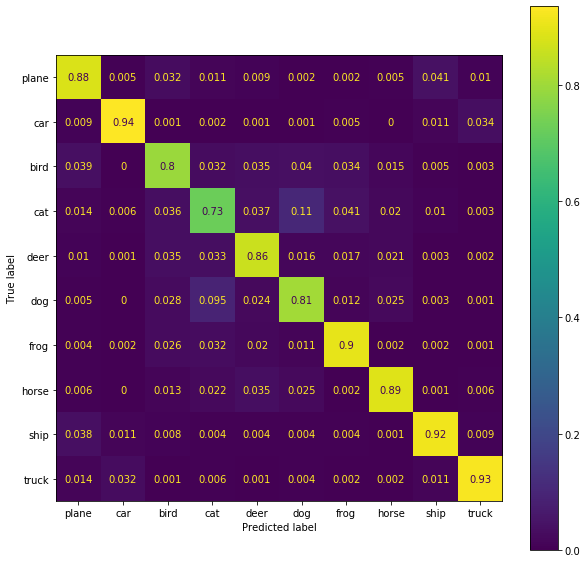

In [49]:
plot_confusion(vgg, confusion)

In [50]:
precision_recall_f1(vgg, y_true, y_pred)

Class  |   Precision  Recall  F1-score 

plane     0.8639921722113503  0.883  0.8733926805143423
car     0.9425981873111783  0.936  0.9392875062719518
bird     0.8157625383828045  0.797  0.806272129489125
cat     0.754149377593361  0.727  0.7403258655804481
deer     0.8385214007782101  0.862  0.8500986193293886
dog     0.7942913385826772  0.807  0.8005952380952381
frog     0.8832188420019627  0.9  0.8915304606240714
horse     0.9072375127420998  0.89  0.8985360928823827
ship     0.9133466135458167  0.917  0.9151696606786427
truck     0.9307228915662651  0.927  0.9288577154308617
